# Classifying SNe

`Authors: Carolina Núñez, Vicente Pedreros, Antonio Vitalic`

The Dark Energy Science Collaboration released a new dataset with simulated light curves from LSST, including many classes of transient and persistent sources, including light curves and host information: [training set](https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/#trainingset)

In this project you are asked to build a classifier that can discriminate between the three classes of SNe: SNII (SNII-Templates, SNII-HostXT_V19 and SNII-NMF), SNIa (SNIa-91bg, SNIa-SALT2 and SNIax) and SNIbc (SNIb+HostXT_V19, SNIb-Templates, SNIc+HostXT_V19, SNIc-Templates, SNIcBL+HostXT_V19).
You can use metadata and light curve information.


Basic libraries are imported. Note that `Table` is used to transform the fits files to a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import fnmatch
import glob

# Display all columns of pandas dataframe
pd.set_option('display.max_columns', None)


## Curating the data

The first thing to do is import the data. The function `to_df` will recieve the path to the first model of each class and return a dataframe. Note that the columns that will be used to classification are in the list `alert_name`.

In [2]:
head_filenames = fnmatch.filter(glob.glob('data_rn/*'), '*HEAD.FITS.gz')
# These are the classes that will be classified
classes = ['SNIa', 'SNIbc', 'SNII']

# The following columns are the ones that will be used for classification
alert_name = ['SNID', 'RA', 'DEC', 'NOBS', 'MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_SPECZ',
              'HOSTGAL_SPECZ_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_ZPHOT_Q000', 'HOSTGAL_ZPHOT_Q010', 'HOSTGAL_ZPHOT_Q020', 'HOSTGAL_ZPHOT_Q030',
              'HOSTGAL_ZPHOT_Q040', 'HOSTGAL_ZPHOT_Q050', 'HOSTGAL_ZPHOT_Q060', 'HOSTGAL_ZPHOT_Q070', 'HOSTGAL_ZPHOT_Q080', 'HOSTGAL_ZPHOT_Q090', 'HOSTGAL_ZPHOT_Q100',
              'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r',
              'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y', 'HOSTGAL2_RA', 'HOSTGAL2_DEC', 'HOSTGAL2_SNSEP', 'HOSTGAL2_SPECZ', 'HOSTGAL2_SPECZ_ERR', 'HOSTGAL2_PHOTOZ',
              'HOSTGAL2_PHOTOZ_ERR', 'HOSTGAL2_ZPHOT_Q000', 'HOSTGAL2_ZPHOT_Q010', 'HOSTGAL2_ZPHOT_Q020', 'HOSTGAL2_ZPHOT_Q030',  'HOSTGAL2_ZPHOT_Q040', 'HOSTGAL2_ZPHOT_Q050',
              'HOSTGAL2_ZPHOT_Q060', 'HOSTGAL2_ZPHOT_Q070', 'HOSTGAL2_ZPHOT_Q080', 'HOSTGAL2_ZPHOT_Q090', 'HOSTGAL2_ZPHOT_Q100', 'HOSTGAL2_MAG_u', 'HOSTGAL2_MAG_g',
              'HOSTGAL2_MAG_r', 'HOSTGAL2_MAG_i', 'HOSTGAL2_MAG_z', 'HOSTGAL2_MAG_Y', 'HOSTGAL2_MAGERR_u', 'HOSTGAL2_MAGERR_g', 'HOSTGAL2_MAGERR_r', 'HOSTGAL2_MAGERR_i',
              'HOSTGAL2_MAGERR_z', 'HOSTGAL2_MAGERR_Y', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']


In [3]:
def to_df(filename):
    """
    This function recieves a filename and will create a dataframe by using the HEAD's and PHOT's files.
    The columns corresponding to simulation information are droppped.
    """
    df_train = Table.read(filename, format='fits').to_pandas()
    for col in ['SNID', 'IAUC', 'SIM_MODEL_NAME', 'SIM_TYPE_NAME']:
        df_train[col] = df_train[col].apply(lambda row: row.decode("utf-8").strip())
    
    df_lc = Table.read(filename.replace("HEAD", "PHOT"), format='fits').to_pandas()
    for col in ['BAND', 'FIELD']:
        df_lc[col] = df_lc[col].apply(lambda row: row.decode("utf-8").strip())

    # The data from HEAD and PHOT are grouped.
    df = df_train.groupby("SNID").apply(lambda df: df_lc.iloc[df.PTROBS_MIN.iloc[0]-1:df.PTROBS_MAX.iloc[0]-1]).reset_index()
    df = pd.merge(df_train, df, left_on='SNID', right_on='SNID')
    
    # Only alert_name columns are considered
    df = df[alert_name]

    subclass = filename.replace('_HEAD.FITS.gz', '').replace('data_rn/', '')  # Name of the subclass
    subclasses = [subclass for x in range(len(df))]  # List of strings containing the name of the subclass

    _class_ = subclass[:4]  # Name of the class
    classes = [_class_ for x in range(len(df))]  # List of strings containing the name of the class

    # A column containing the class and subclass are added
    df.insert(0, 'SUBCLASS', subclasses)
    df.insert(0, 'CLASS', classes)
    df.replace(['SNIb', 'SNIc'], 'SNIbc', inplace=True)

    return df

In [4]:
dataframes = [to_df(filename) for filename in head_filenames]

df_train = pd.concat(dataframes)
df_train


,CLASS,SUBCLASS,SNID,RA,DEC,NOBS,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_MAGERR_Y,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,MJD,BAND,FLUXCAL,FLUXCALERR
0,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60442.4130,i,-1.563279,11.344539
1,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60444.4280,r,3.731861,4.645030
2,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60457.4187,Y,-17.873014,42.014057
3,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.341763,22.141100,22.007923,0.0770,0.00882,0.0062,0.00644,0.00792,0.01347,329.906498,1.657871,4.21659,0.24614,0.0005,0.198517,0.03308,0.022607,0.190447,0.201237,0.209017,0.215657,0.221877,0.228087,0.234727,0.242507,0.253297,0.421137,20.172285,19.025768,18.135046,17.736671,17.438961,17.252865,0.00551,0.00501,0.005,0.005,0.005,0.00501,60457.4293,z,12.042594,25.301315
4,SNII,SNII+HostXT_V19,31254142,329.905628,1.658841,125,0.045899,0.002295,0.275117,0.03452,329.905489,1.659181,0.639239,-9.0,-9.0,0.275117,0.03452,0.067207,0.242327,0.253587,0.261697,0.268637,0.275117,0.281597,0.288537,0.296657,0.307907,0.483037,24.296394,23.346228,22.654875,22.3

In [5]:
df = df_train[['SNID', 'CLASS', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']].copy()
df


,SNID,CLASS,MJD,BAND,FLUXCAL,FLUXCALERR
0,31254142,SNII,60442.4130,i,-1.563279,11.344539
1,31254142,SNII,60444.4280,r,3.731861,4.645030
2,31254142,SNII,60457.4187,Y,-17.873014,42.014057
3,31254142,SNII,60457.4293,z,12.042594,25.301315
4,31254142,SNII,60463.4195,i,2.557573,6.018558
...,...,...,...,...,...,...
118810,15480123,SNIbc,60961.0854,i,-10.518693,8.376203
118811,15480123,SNIbc,60961.1019,z,8.501602,15.873994
118812,15480123,SNIbc,60967.0495,r,1.206127,3.369061
118813,15480123,SNIbc,60967.0664,i,-8.784276,3.759806


### Visualization of data

A count plot, 20 lightcurves per class and histograms are presented.

In [6]:
ax = df.groupby('SNID').max().CLASS.value_counts().plot.bar()


In [ ]:
colors = {'u': 'b', 'g': 'g', 'r': 'r', 'i': 'orange', 'z': 'brown', 'Y': 'k'}


In [ ]:
def plot_lc(SNID, df, path=None):
    """
    Plots the lightcurves, generating a lightcurve (lc) for each band, but it shows
    all bands in one figure.
    """
    fig, ax = plt.subplots(figsize=(8, 3))
    for idx, c in enumerate(colors.keys()):
        mask = (df.SNID == str(SNID)) & (df.BAND == c)
        if mask.sum() > 0:
            ax.errorbar(df.loc[mask].MJD, df.loc[mask].FLUXCAL,
                        yerr=df.loc[mask].FLUXCALERR, color=list(colors.values())[idx], fmt='o', ms=3, lw=0, elinewidth=1, label=c)

    ax.set_xlabel('mjd')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.set_title(str(SNID) + ' ' + df.loc[mask].iloc[0].CLASS)
    if path is not None:
        fig.savefig(path+'lc_'+SNID+'.png')


In [ ]:
np.random.seed(73)

snids_20sample = [list(df.loc[df.CLASS.isin([df.CLASS.unique()[i]])].sample(
    20).SNID) for i in range(len(df.CLASS.unique()))]

snids_20 = sum(snids_20sample, [])


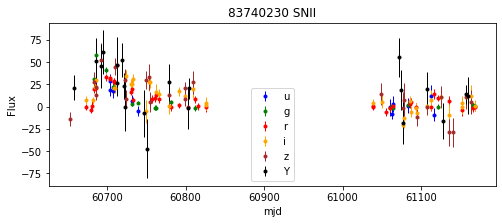

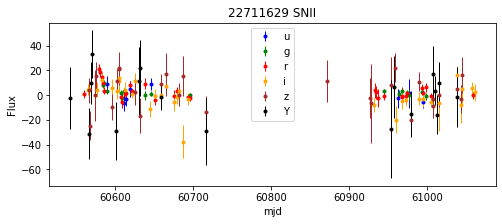

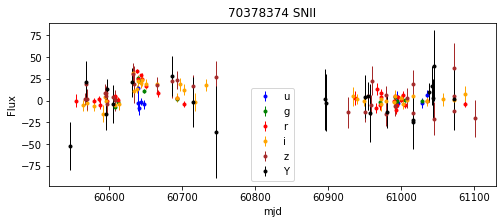

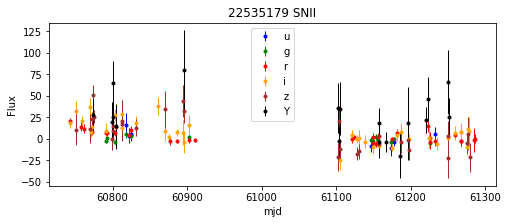

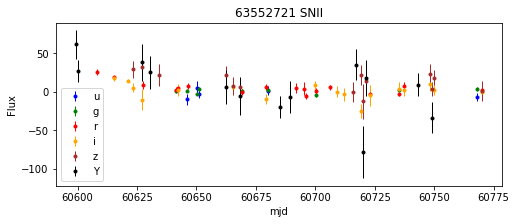

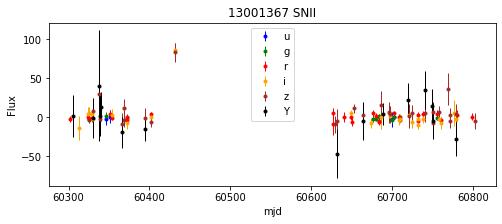

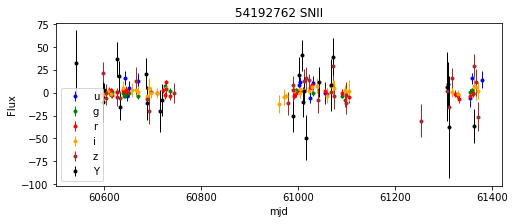

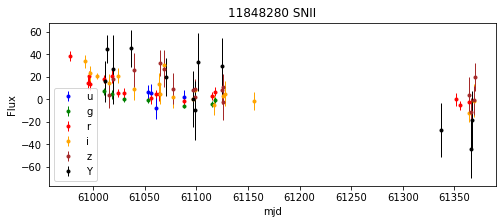

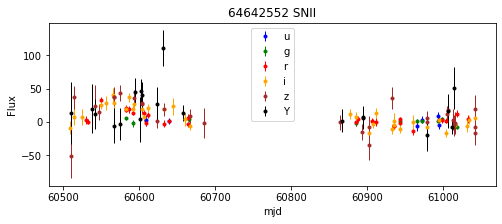

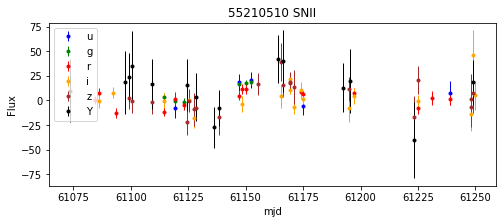

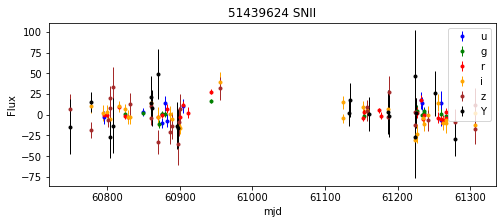

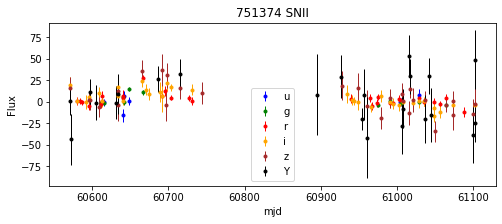

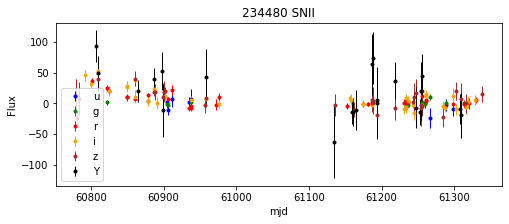

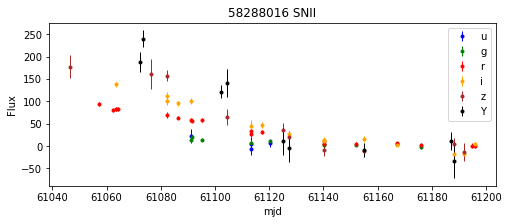

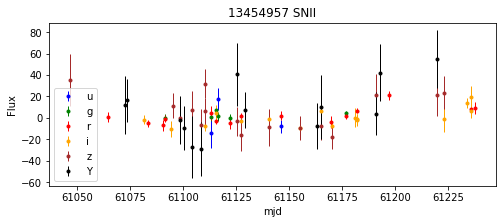

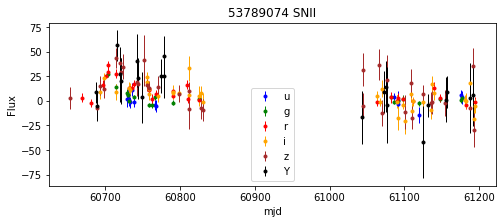

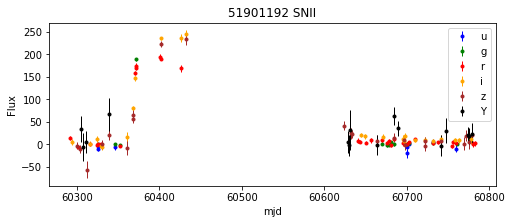

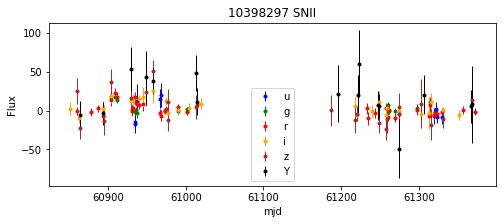

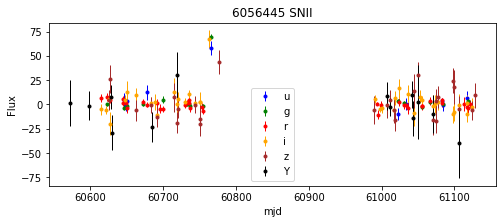

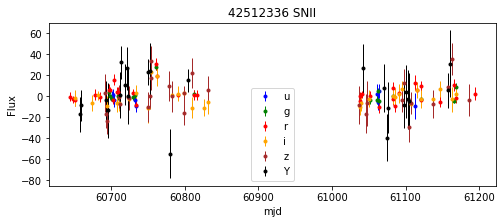

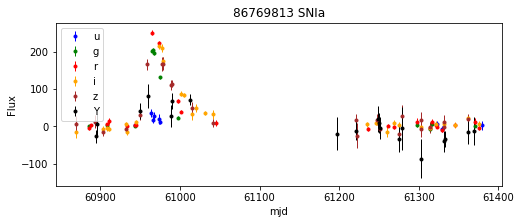

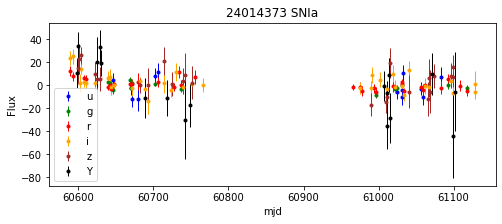

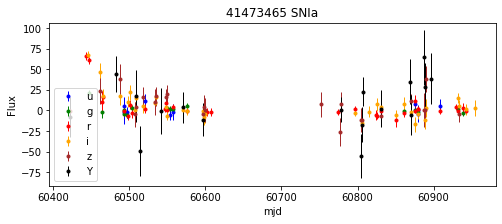

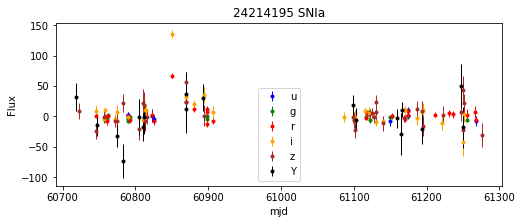

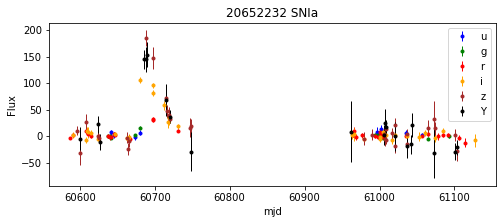

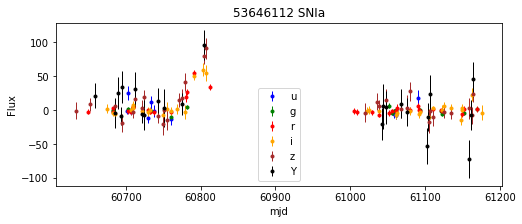

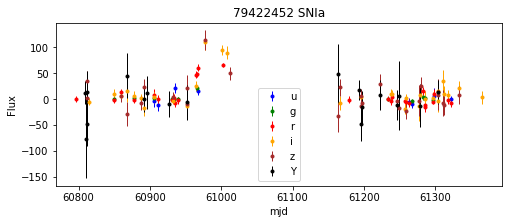

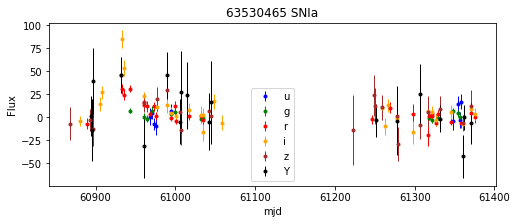

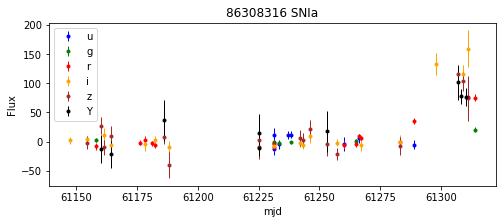

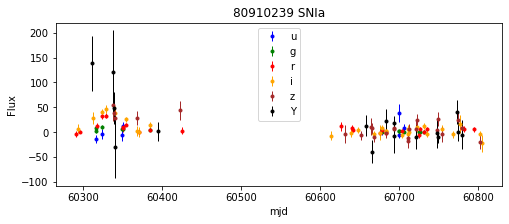

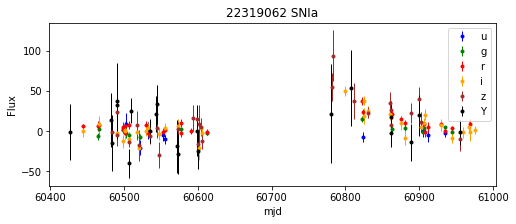

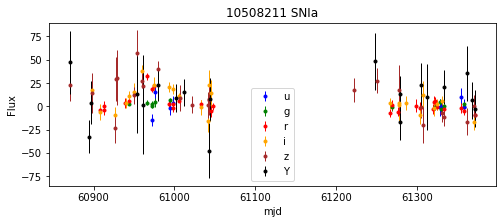

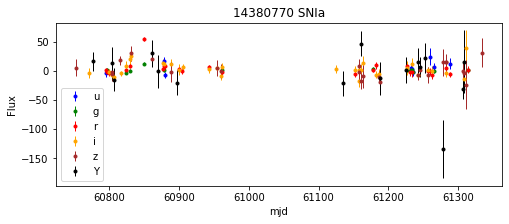

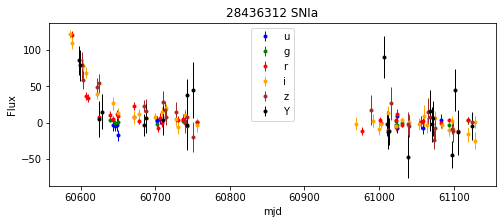

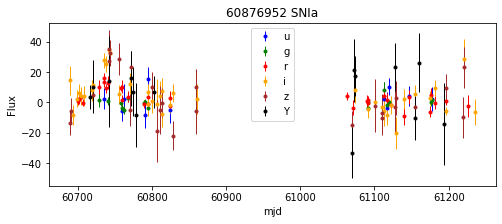

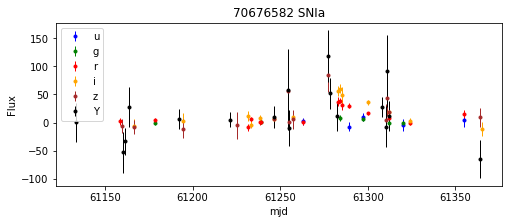

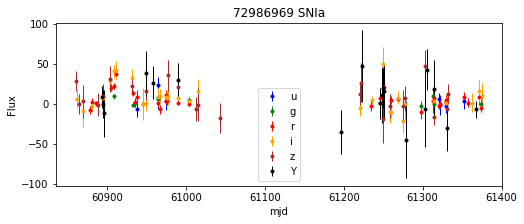

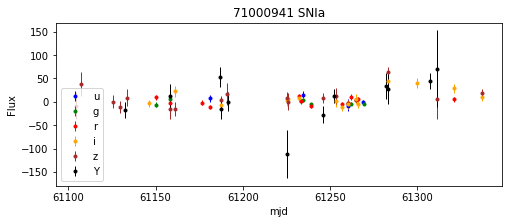

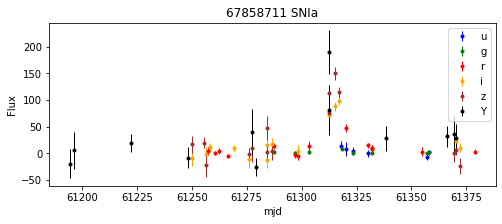

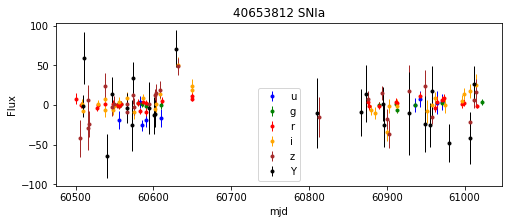

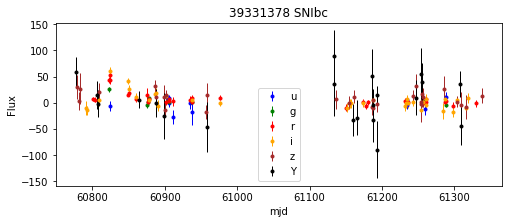

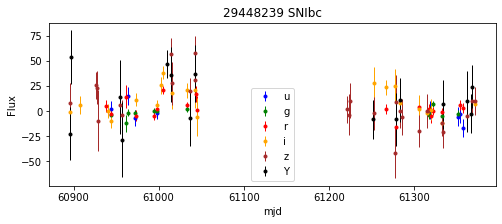

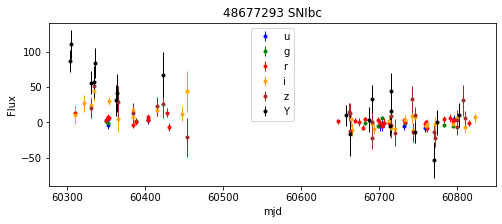

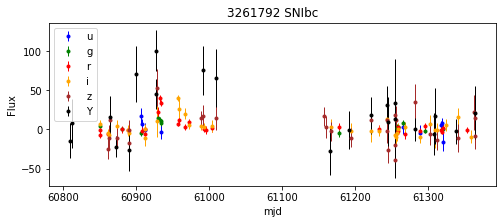

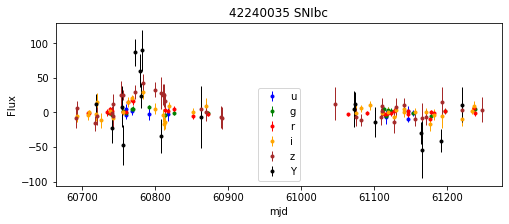

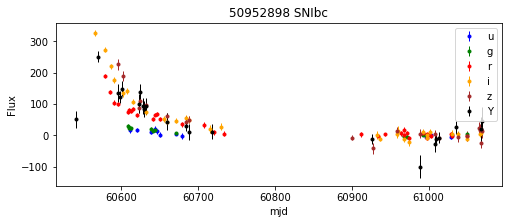

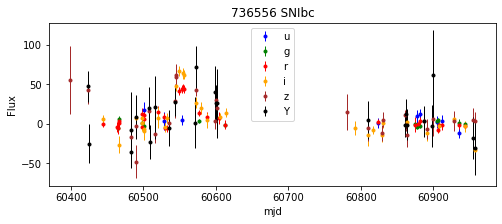

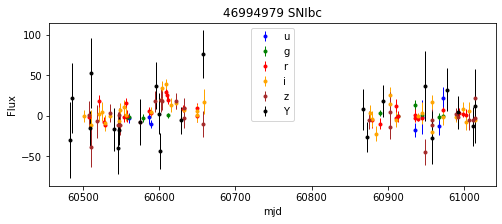

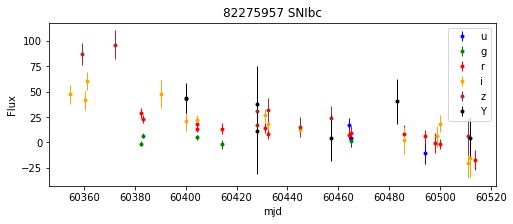

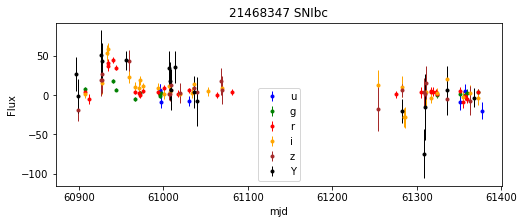

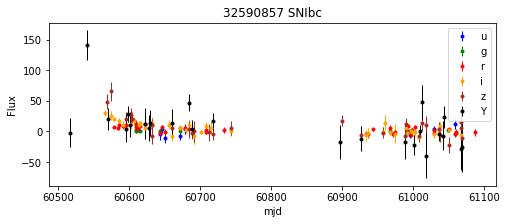

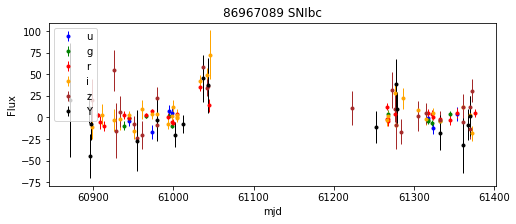

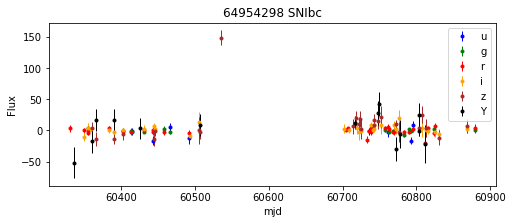

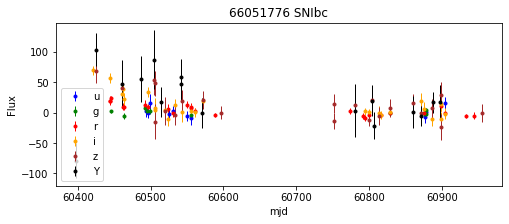

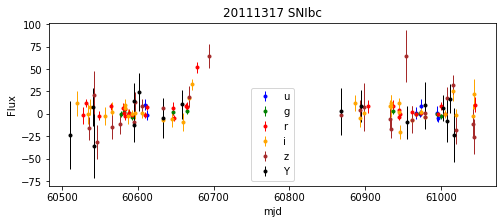

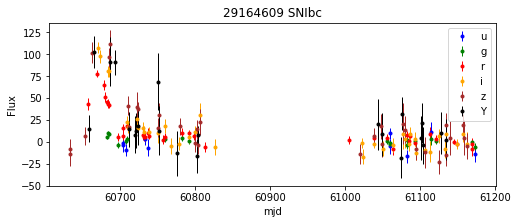

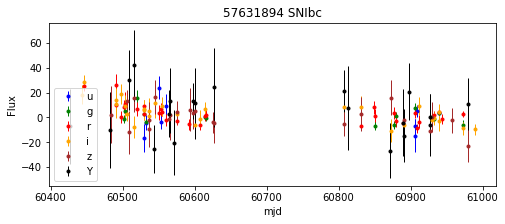

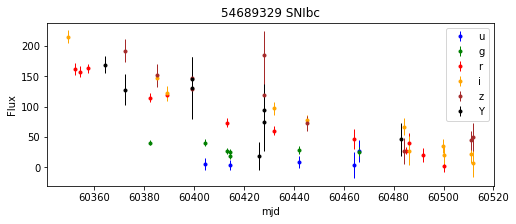

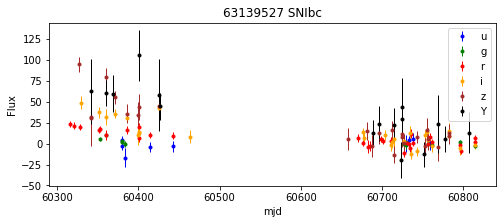

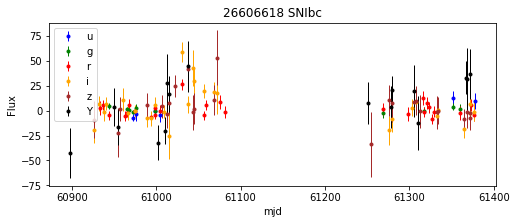

In [ ]:
for snid in snids_20:
    plot_lc(str(snid), df, path='images/lightcurves/')
    plt.show()


Text(0.5, 1.0, 'Flux histogram')

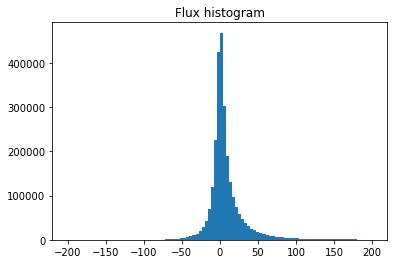

In [ ]:
# Histograma de flujos de todos los datos
counts, bins = np.histogram(
    df.FLUXCAL.to_numpy(), bins=100, range=(-200, 200))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Flux histogram')


Text(0.5, 1.0, 'Flux error histogram')

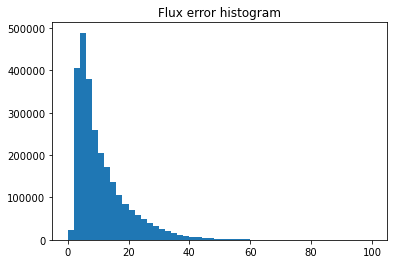

In [ ]:
# Flux Error Histogram
counts, bins = np.histogram(
    df.FLUXCALERR.to_numpy(), bins=50, range=(0, 100))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Flux error histogram')


Text(0.5, 1.0, 'Signal to noise ratio histogram')

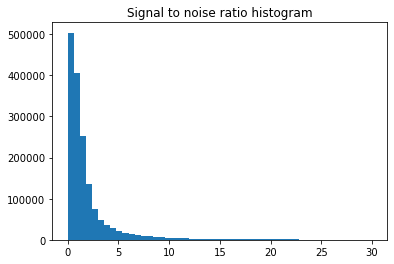

In [ ]:
# SNR Histogram
counts, bins = np.histogram(df.FLUXCAL.to_numpy(
)/df.FLUXCALERR.to_numpy(), bins=50, range=(0, 30))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Signal to noise ratio histogram')


Text(0.5, 1.0, 'Number of observations histogram')

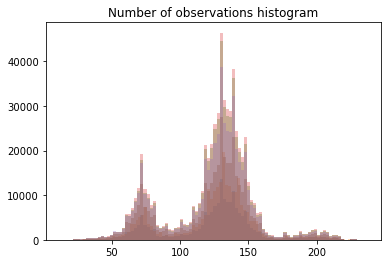

In [ ]:
# Number of observations Histogram

fig, ax = plt.subplots()
for c in list(colors.keys()):
    counts, bins = np.histogram(
        df_train.loc[df_train.BAND == c].NOBS.to_numpy(), bins=100)
    ax.hist(bins[:-1], bins, weights=counts, alpha=0.3)
plt.title('Number of observations histogram')


## Building images

The goal of this section is to build images so a Neural Network can perform classification.

Since most of the objects have a NOBS higher than 60, images will consist in matrixes of 6 x 60, where each row will represent a band.

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df.BAND = encoder.fit_transform(df.BAND)

color = np.sort(df.BAND.unique())
color


array([0, 1, 2, 3, 4, 5])

To split the data into training and test sets, the fact that the dataframe contains multiple rows for an object needs to be considered. So, the array containing the SNID's (`snids_array`) will be splitted into a train and test array.

In [ ]:
from sklearn.model_selection import train_test_split

snids = df.SNID.unique()

snids_train, snids_test = train_test_split(
    snids, test_size=0.4, random_state=1)


In [ ]:
X_df_train = df.loc[df.SNID.isin(
    snids_train)].drop('CLASS', axis=1)
X_df_test = df.loc[df.SNID.isin(
    snids_test)].drop('CLASS', axis=1)

y_train = df.loc[df.SNID.isin(snids_train)]['CLASS']
y_test = df.loc[df.SNID.isin(snids_test)]['CLASS']


In [ ]:
snids_train = X_df_train.SNID.unique()
snids_test = X_df_test.SNID.unique()

In [ ]:
X_train_time = np.zeros((len(snids_train), 6, 30))
X_train_flux = np.zeros((len(snids_train), 6, 30))
X_train_fluxerr = np.zeros((len(snids_train), 6, 30))

for i in range(len(snids_train)):
    for c in color:
        mask = (df.SNID == snids_train[i]) & (df.BAND == c)
        df_mask = df.loc[mask]

        times = df_mask.MJD.to_numpy()
        flux = df_mask.FLUXCAL.to_numpy()
        fluxerr = df_mask.FLUXCALERR.to_numpy()

        out_time = np.zeros(30)
        out_time[:len(times)] = times[:30]
        out_flux = np.zeros(30)
        out_flux[:len(fluxerr)] = flux[:30]
        out_fluxerr = np.zeros(30)
        out_fluxerr[:len(fluxerr)] = fluxerr[:30]

        X_train_time[i][c] = out_time
        X_train_flux[i][c] = out_flux
        X_train_fluxerr[i][c] = out_fluxerr


NameError: name 'snids_train' is not defined

In [ ]:
X_test_time = np.zeros((len(snids_test), 6, 30))
X_test_flux = np.zeros((len(snids_test), 6, 30))
X_test_fluxerr = np.zeros((len(snids_test), 6, 30))

for i in range(len(snids_test)):
    for c in color:
        mask = (df.SNID == snids_test[i]) & (df.BAND == c)
        df_mask = df.loc[mask]

        times = df_mask.MJD.to_numpy()
        flux = df_mask.FLUXCAL.to_numpy()
        fluxerr = df_mask.FLUXCALERR.to_numpy()

        out_time = np.zeros(30)
        out_time[:len(times)] = times[:30]
        out_flux = np.zeros(30)
        out_flux[:len(fluxerr)] = flux[:30]
        out_fluxerr = np.zeros(30)
        out_fluxerr[:len(fluxerr)] = fluxerr[:30]

        X_test_time[i][c] = out_time
        X_test_flux[i][c] = out_flux
        X_test_fluxerr[i][c] = out_fluxerr


In [ ]:
X60_test_fluxerr = np.zeros((len(snids_test), 6, 60))

for i in range(len(snids_test)):
    for c in color:
        mask = (df.SNID == snids_test[i]) & (df.BAND == c)
        data = df.loc[mask].FLUXCALERR.to_numpy()
        output = np.zeros(60)
        output[:len(data)] = data
        X60_test_fluxerr[i][c] = output


In [ ]:
imgs = {'time_train': X60_train_time, 'flux_train': X60_train_flux, 'fluxerr_train': X60_train_fluxerr,
        'time_test': X60_test_times, 'flux_test': X60_test_flux, 'fluxerr_test': X60_test_fluxerr}


In [ ]:
# Saving the arrays. Note that the reshape is done since a 3D array can't be stored

for img in imgs.keys():
    np.savetxt(img + '.csv', imgs[img].reshape(imgs[img].shape[0], -1))


In [ ]:
# Loading the arrays
for img in ['time_train.csv', 'flux_train.csv', 'fluxerr_train.csv', 'time_test.csv', 'flux_test.csv', 'fluxerr_test.csv']:
    np.loadtxt(img)

original_array = loaded_array.reshape(
    loaded_array.shape[0], loaded_array.shape[1] // 60, 60)

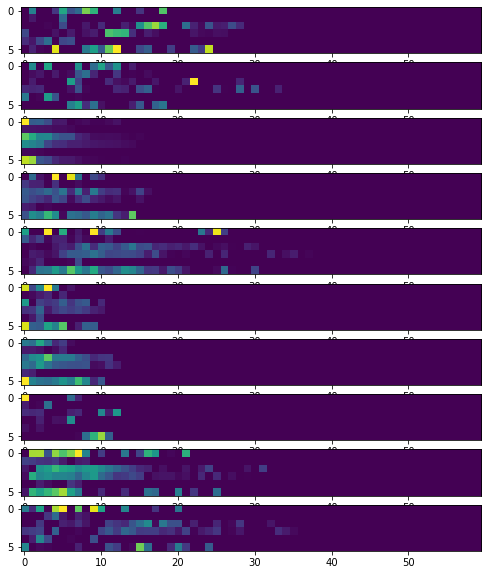

In [ ]:
fig, ax = plt.subplots(10, figsize=(100, 10))

for i in range(10):
    ax[i].imshow(X60_train_flux[i], vmin=0)

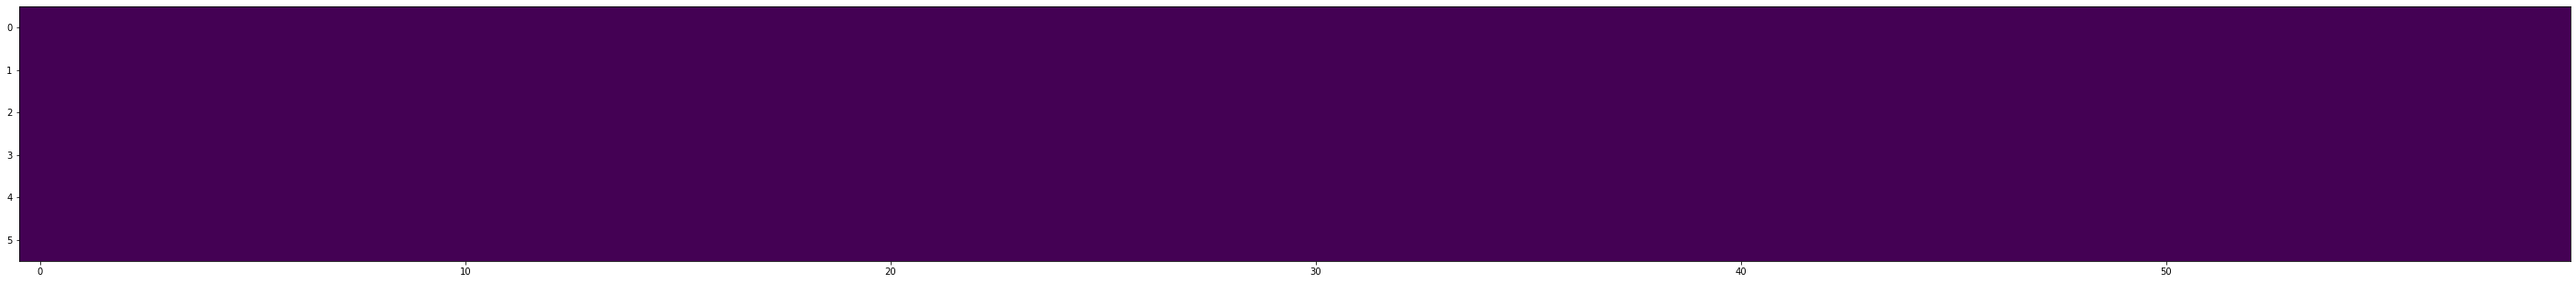

In [ ]:
fig, ax = plt.subplots(figsize=(50, 10))
ax.imshow(X60_train_flux[205], vmin=0)


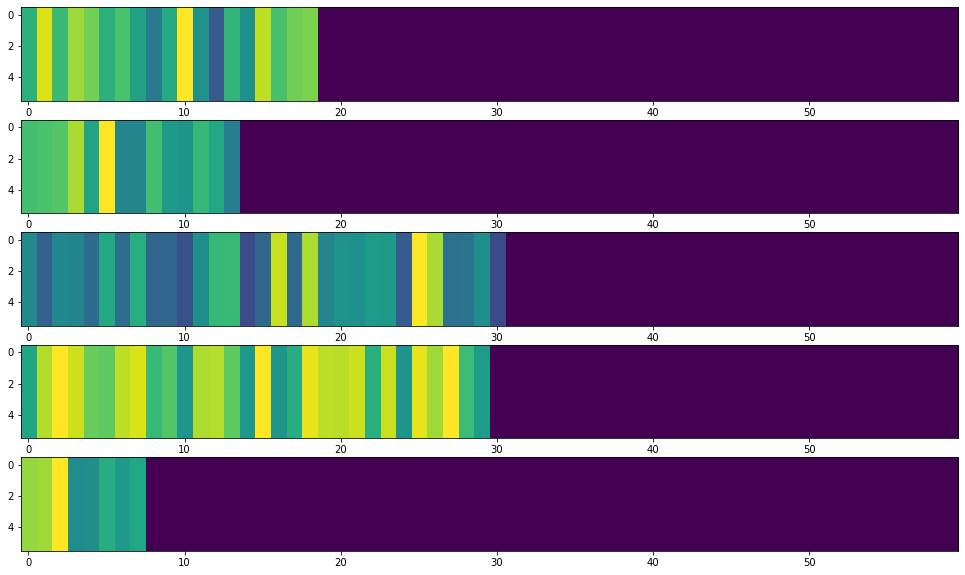

In [ ]:
fig, ax = plt.subplots(5, figsize=(50, 10))

for i in range(5):
    ax[i].imshow(X60_train_fluxerr[i], vmin=0)
